# Import

The first step is to import all required modules and open the CSVs to make sure everything is running correctly.

In [174]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import sklearn as sk
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score,mean_squared_error,mean_absolute_error,confusion_matrix, r2_score
from sklearn.linear_model import LinearRegression
import time
from datetime import datetime
import joblib

In [175]:
url = 'https://raw.githubusercontent.com/vkoul/data/main/misc/' 

listings = pd.read_csv(url + "aibnb_listings.csv")

users = pd.read_csv(url + "airbnb_users.csv")

All the time columns were converted to datetime, to make sure there are no issues when running the code.

In [176]:
def my_datetime_parser(date_str):
    for form in ("%Y-%m-%d %H:%M:%S", "%Y-%m-%d %H:%M:%S.%f"):
        try:
            return pd.to_datetime(date_str, format = form)
        except:
            continue
    return pd.NaT

In [177]:
date_list = ['ts_interaction_first', 'ts_reply_at_first', 'ts_accepted_at_first','ts_booking_at','ds_checkin_first', 'ds_checkout_first' ]
contacts = pd.read_csv(url + "airbnb_contacts.csv", parse_dates = date_list)
contacts['ts_interaction_first'] = contacts['ts_interaction_first'].apply(my_datetime_parser)


# General Dataframe info

In this section all dataframes are checked to make sure there are no missing values, duplicates or wrong data types. 

In [178]:
contacts.head()

,id_guest_anon,id_host_anon,id_listing_anon,ts_interaction_first,ts_reply_at_first,ts_accepted_at_first,ts_booking_at,ds_checkin_first,ds_checkout_first,m_guests,m_interactions,m_first_message_length_in_characters,contact_channel_first,guest_user_stage_first
0,da8656a1-51af-4f38-b1c4-94be1f585157,5426897d-960d-4013-9e38-606ae746793c,a408a8b2-0d44-4513-a611-3736d0409bb2,2016-04-21 02:55:53,2016-04-21 03:15:00,2016-04-21 03:15:00,2016-04-21 03:15:00,2016-08-02,2016-08-06,4.0,30,31.0,book_it,past_booker
1,8590d6f1-8bc9-4e8b-bdfb-de78f69fcf37,f30417c5-6df4-45ac-bfc2-6ad1cce398ab,e387c705-0aeb-464c-9375-ece63be6f006,2016-02-16 22:14:01,2016-02-16 23:37:36,NaT,NaT,2016-08-11,2016-08-22,5.0,2,312.0,contact_me,past_booker
2,ebcd83ba-bda1-47eb-9680-2dd04ccf3988,13cbf50a-3272-45d4-9866-a06b6ea1b99a,d1eb1960-938f-4305-a353-51e224414dd4,2016-01-27 23:33:38,2016-01-28 02:12:47,NaT,NaT,2016-03-14,2016-03-23,1.0,3,164.0,contact_me,new
3,b0af8848-fe2a-4ef1-991e-26ab3066feb3,01614601-d5a4-4776-ab9b-c10d3b865bf0,855f6779-346c-45fc-a64b-ea133250ca7a,2016-05-05 14:42:52,2016-05-05 15:17:40,2016-05-05 15:17:40,NaT,2016-05-27,2016-05-29,2.0,3,203.0,contact_me,new
4,5ddbbcc3-ac1a-4d8a-b6f8-0f675b76d1b2,f2fed6f3-4c5c-453d-9e64-37c62b8bd06d,f2928a59-c5e7-42b2-9c37-240a40f38dc0,2016-06-23 03:09:25,2016-06-23 03:09:26,2016-06-23 03:09:33,2016-06-23 03:09:33,2016-08-19,2016-08-21,3.0,25,0.0,instant_book,past_booker


In [179]:
contacts.shape

(27887, 14)

In [180]:
contacts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27887 entries, 0 to 27886
Data columns (total 14 columns):
 #   Column                                Non-Null Count  Dtype         
---  ------                                --------------  -----         
 0   id_guest_anon                         27887 non-null  object        
 1   id_host_anon                          27887 non-null  object        
 2   id_listing_anon                       27887 non-null  object        
 3   ts_interaction_first                  27887 non-null  datetime64[ns]
 4   ts_reply_at_first                     25855 non-null  datetime64[ns]
 5   ts_accepted_at_first                  16415 non-null  datetime64[ns]
 6   ts_booking_at                         11587 non-null  datetime64[ns]
 7   ds_checkin_first                      27887 non-null  datetime64[ns]
 8   ds_checkout_first                     27887 non-null  datetime64[ns]
 9   m_guests                              27886 non-null  float64       
 10

In [181]:
contacts.isna().sum()

id_guest_anon                               0
id_host_anon                                0
id_listing_anon                             0
ts_interaction_first                        0
ts_reply_at_first                        2032
ts_accepted_at_first                    11472
ts_booking_at                           16300
ds_checkin_first                            0
ds_checkout_first                           0
m_guests                                    1
m_interactions                              0
m_first_message_length_in_characters        0
contact_channel_first                       0
guest_user_stage_first                      0
dtype: int64

In [182]:
contacts.duplicated().sum()

0

In [183]:
listings.head()

,id_listing_anon,room_type,listing_neighborhood,total_reviews
0,71582793-e5f8-46d7-afdf-7a31d2341c79,Private room,-unknown-,0.0
1,a1a3f728-e21f-4432-96aa-361d28e2b319,Entire home/apt,Copacabana,0.0
2,353a68be-ecf9-4b7b-9533-c882dc2f0760,Entire home/apt,Barra da Tijuca,3.0
3,b9ae1908-0486-40ac-bbcf-bd63ffebfe63,Entire home/apt,Lapa,4.0
4,fa0290ef-7881-4482-8981-8ebb1ce5dbfd,Entire home/apt,-unknown-,0.0


In [184]:
listings.shape

(13038, 4)

In [185]:
listings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13038 entries, 0 to 13037
Data columns (total 4 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id_listing_anon       13038 non-null  object 
 1   room_type             13038 non-null  object 
 2   listing_neighborhood  13038 non-null  object 
 3   total_reviews         13038 non-null  float64
dtypes: float64(1), object(3)
memory usage: 407.6+ KB


In [186]:
listings.isna().sum()

id_listing_anon         0
room_type               0
listing_neighborhood    0
total_reviews           0
dtype: int64

In [187]:
listings.duplicated().sum()

0

In [188]:
users.rename(columns = {'id_user_anon': 'id_guest_anon'}, inplace = True)

In [189]:
users.head()

,id_guest_anon,country,words_in_user_profile
0,1d16a001-31a2-494c-a101-1f7b308adc62,FR,0
1,42607e0a-86c0-472e-b633-9e192114e93c,AR,0
2,25f85eb5-a700-44e1-b142-4c076222198d,BR,0
3,55abeba0-18ef-4c58-80f4-3c278b706aca,BR,1
4,5d62d35a-7d6d-45dd-ae9b-a5d2f82a7d7b,BR,98


In [190]:
users.shape

(31525, 3)

In [191]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31525 entries, 0 to 31524
Data columns (total 3 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id_guest_anon          31525 non-null  object
 1   country                31524 non-null  object
 2   words_in_user_profile  31525 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 739.0+ KB


In [192]:
users.isna().sum()

id_guest_anon            0
country                  1
words_in_user_profile    0
dtype: int64

In [193]:
users.duplicated().sum()

68

In [194]:
users = users.drop_duplicates()

In this specific case, since the users data frame had duplicates they had to be dropped.

# Data Cleaning

In [195]:
contacts = contacts.dropna(subset = ['m_guests'])

In [196]:
print(len(contacts[contacts['ts_reply_at_first'] < contacts['ts_interaction_first']]))
print(len(contacts[contacts['ts_accepted_at_first'] < contacts['ts_reply_at_first']]))
print(len(contacts[contacts['ts_booking_at'] < contacts['ts_accepted_at_first']]))

452
0
0


In [197]:
contacts = contacts[~(contacts['ts_reply_at_first'] < contacts['ts_interaction_first'])]
print(len(contacts[contacts['ts_reply_at_first'] < contacts['ts_interaction_first']]))

0


In [198]:
print(len(contacts))
print(len(contacts[contacts['guest_user_stage_first'] == '-unknown-']))
contacts = contacts[contacts['guest_user_stage_first'] != '-unknown-']

27434
33


# Correlation

In [199]:
contacts_listings = contacts.merge(listings, on = 'id_listing_anon')

In [200]:
contacts_listings['booked'] = contacts_listings['ts_booking_at'].notna()
contacts_listings['diff_reply_interaction'] = contacts_listings['ts_reply_at_first']- contacts_listings['ts_interaction_first']
contacts_listings['time_of_booking'] = contacts_listings['ts_booking_at']- contacts_listings['ts_accepted_at_first']
contacts_listings['hour'] = contacts_listings['ts_interaction_first'].dt.hour
contacts_listings.head()

,id_guest_anon,id_host_anon,id_listing_anon,ts_interaction_first,ts_reply_at_first,ts_accepted_at_first,ts_booking_at,ds_checkin_first,ds_checkout_first,m_guests,...,m_first_message_length_in_characters,contact_channel_first,guest_user_stage_first,room_type,listing_neighborhood,total_reviews,booked,diff_reply_interaction,time_of_booking,hour
0,da8656a1-51af-4f38-b1c4-94be1f585157,5426897d-960d-4013-9e38-606ae746793c,a408a8b2-0d44-4513-a611-3736d0409bb2,2016-04-21 02:55:53,2016-04-21 03:15:00,2016-04-21 03:15:00,2016-04-21 03:15:00,2016-08-02,2016-08-06,4.0,...,31.0,book_it,past_booker,Entire home/apt,Copacabana,9.0,True,0 days 00:19:07,0 days,2
1,8590d6f1-8bc9-4e8b-bdfb-de78f69fcf37,f30417c5-6df4-45ac-bfc2-6ad1cce398ab,e387c705-0aeb-464c-9375-ece63be6f006,2016-02-16 22:14:01,2016-02-16 23:37:36,NaT,NaT,2016-08-11,2016-08-22,5.0,...,312.0,contact_me,past_booker,Entire home/apt,Copacabana,0.0,False,0 days 01:23:35,NaT,22
2,ebcd83ba-bda1-47eb-9680-2dd04ccf3988,13cbf50a-3272-45d4-9866-a06b6ea1b99a,d1eb1960-938f-4305-a353-51e224414dd4,2016-01-27 23:33:38,2016-01-28 02:12:47,NaT,NaT,2016-03-14,2016-03-23,1.0,...,164.0,contact_me,new,Private room,Vidigal,49.0,False,0 days 02:39:09,NaT,23
3,3b6d161c-0451-4e71-9896-026e2503dc38,13cbf50a-3272-45d4-9866-a06b6ea1b99a,d1eb1960-938f-4305-a353-51e224414dd4,2016-05-23 12:37:44,2016-05-23 13:12:10,NaT,NaT,2016-06-11,2016-06-17,1.0,...,1478.0,contact_me,past_booker,Private room,Vidigal,49.0,False,0 days 00:34:26,NaT,12
4,87e3f72d-c63e-4410-b681-aea758c72116,13cbf50a-3272-45d4-9866-a06b6ea1b99a,d1eb1960-938f-4305-a353-51e224414dd4,2016-05-29 21:39:16,2016-05-29 21:39:16,2016-05-29 21:39:16,2016-05-29 21:39:16,2016-06-03,2016-06-04,1.0,...,92.0,instant_book,past_booker,Private room,Vidigal,49.0,True,0 days 00:00:00,0 days,21


In [201]:
contacts_listings_dummies = pd.get_dummies(contacts_listings,columns = ['contact_channel_first','guest_user_stage_first','room_type'])
contacts_listings_dummies = contacts_listings_dummies.drop(columns = ['id_guest_anon','id_host_anon', 'id_listing_anon','listing_neighborhood']).reset_index()
contacts_listings_dummies.head()

,index,ts_interaction_first,ts_reply_at_first,ts_accepted_at_first,ts_booking_at,ds_checkin_first,ds_checkout_first,m_guests,m_interactions,m_first_message_length_in_characters,...,time_of_booking,hour,contact_channel_first_book_it,contact_channel_first_contact_me,contact_channel_first_instant_book,guest_user_stage_first_new,guest_user_stage_first_past_booker,room_type_Entire home/apt,room_type_Private room,room_type_Shared room
0,0,2016-04-21 02:55:53,2016-04-21 03:15:00,2016-04-21 03:15:00,2016-04-21 03:15:00,2016-08-02,2016-08-06,4.0,30,31.0,...,0 days,2,True,False,False,False,True,True,False,False
1,1,2016-02-16 22:14:01,2016-02-16 23:37:36,NaT,NaT,2016-08-11,2016-08-22,5.0,2,312.0,...,NaT,22,False,True,False,False,True,True,False,False
2,2,2016-01-27 23:33:38,2016-01-28 02:12:47,NaT,NaT,2016-03-14,2016-03-23,1.0,3,164.0,...,NaT,23,False,True,False,True,False,False,True,False
3,3,2016-05-23 12:37:44,2016-05-23 13:12:10,NaT,NaT,2016-06-11,2016-06-17,1.0,14,1478.0,...,NaT,12,False,True,False,False,True,False,True,False
4,4,2016-05-29 21:39:16,2016-05-29 21:39:16,2016-05-29 21:39:16,2016-05-29 21:39:16,2016-06-03,2016-06-04,1.0,5,92.0,...,0 days,21,False,False,True,False,True,False,True,False


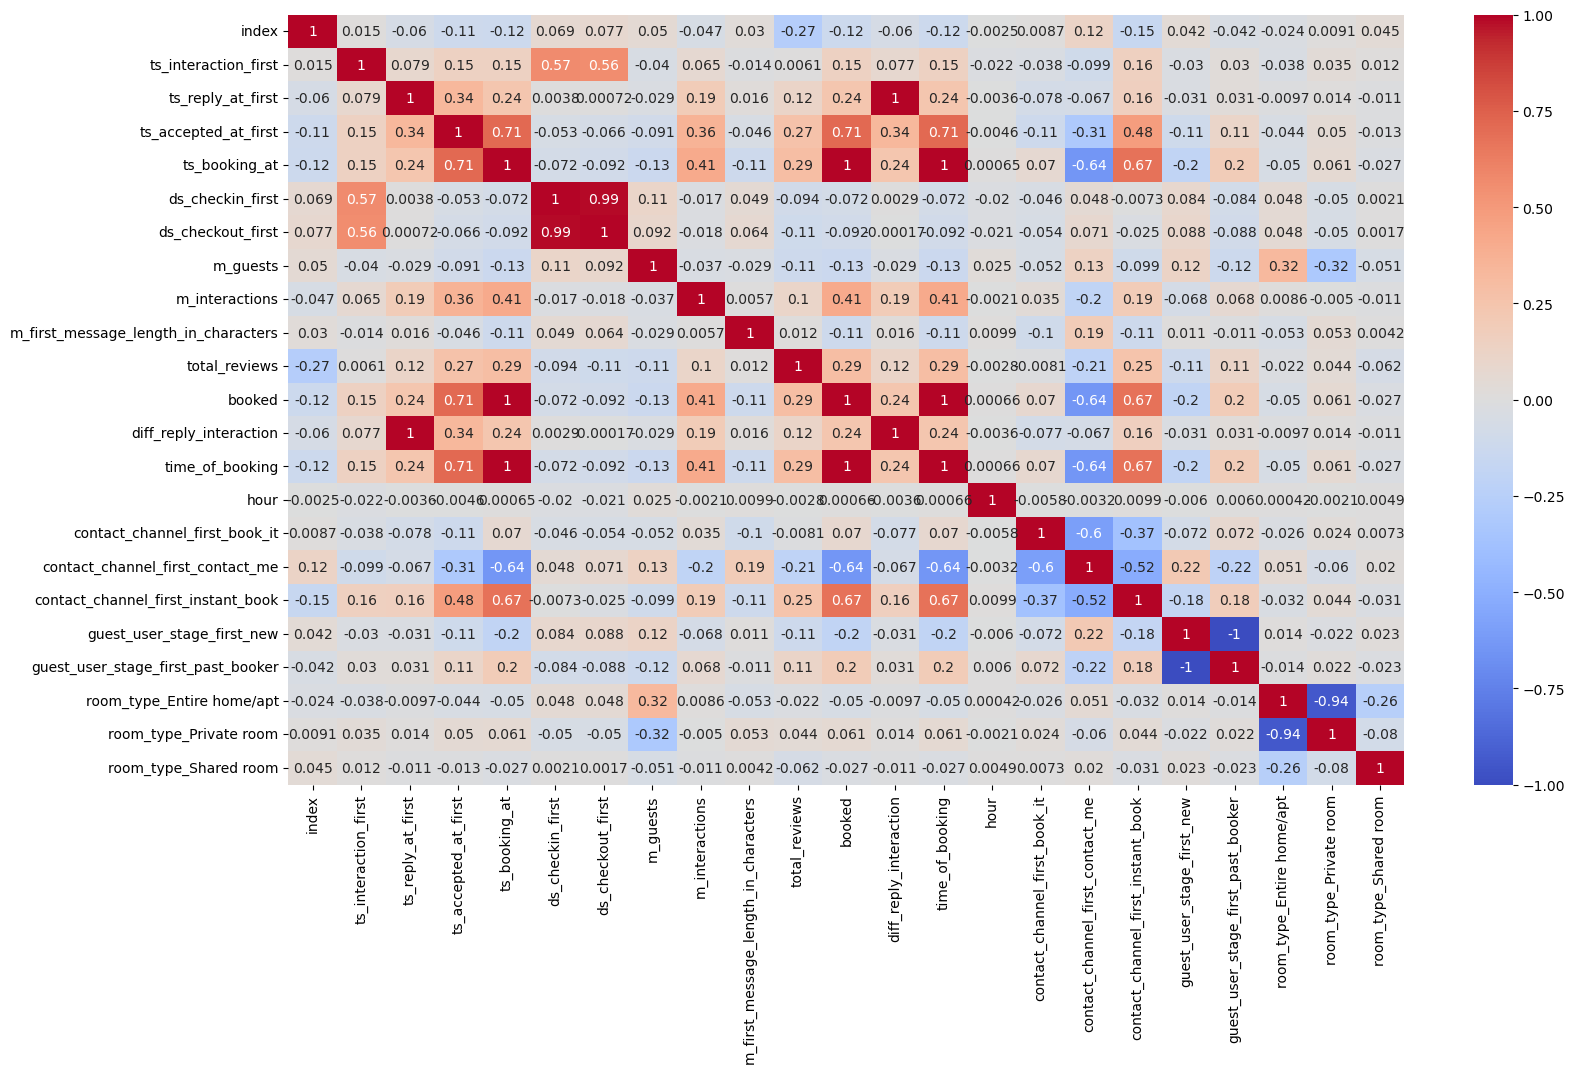

In [202]:
contacts_corr = contacts_listings_dummies.corr()
plt.figure(figsize = (18,10))
sns.heatmap(contacts_corr, annot = True, cmap = 'coolwarm')
plt.show()

# Percentage of bookings received per contact channel

In [203]:
booking_contchannel_all = contacts.groupby('contact_channel_first').size().reset_index(name = 'count')
booking_contchannel_all.sort_values(by = 'count', inplace = True, ascending = False)
booking_contchannel_all.head()

,contact_channel_first,count
1,contact_me,12538
0,book_it,8180
2,instant_book,6683


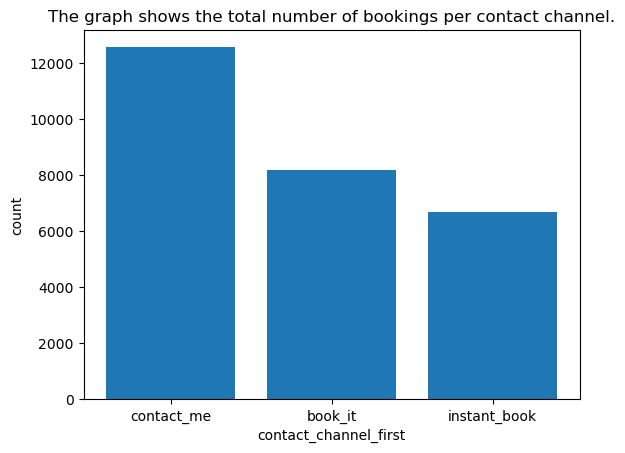

In [204]:
plt.bar(booking_contchannel_all['contact_channel_first'], booking_contchannel_all['count'])
plt.xticks(booking_contchannel_all['contact_channel_first'], ['contact_me', 'book_it','instant_book'])
plt.xlabel('contact_channel_first')
plt.ylabel('count')
plt.title('The graph shows the total number of bookings per contact channel.')
plt.show()

In [205]:
booking_contchannel_yes = contacts[contacts['ts_booking_at'].notna()]
booking_contchannel_yes = booking_contchannel_yes.groupby('contact_channel_first').size().reset_index(name = 'count')
booking_contchannel_yes.sort_values(by = 'count', inplace = True)
booking_contchannel_yes.head()

,contact_channel_first,count
1,contact_me,888
0,book_it,3842
2,instant_book,6683


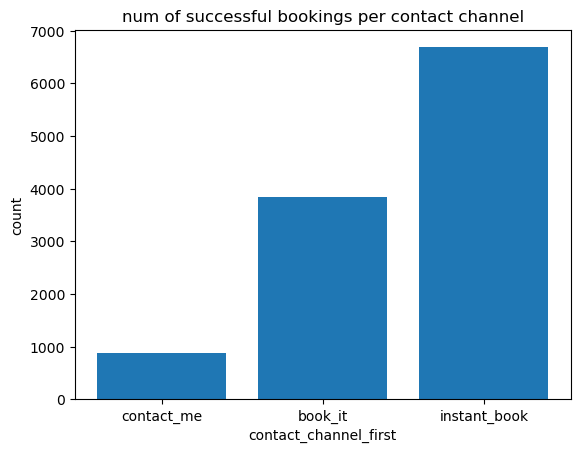

In [206]:
plt.bar(booking_contchannel_yes['contact_channel_first'], booking_contchannel_yes['count'])
plt.xticks(booking_contchannel_yes['contact_channel_first'], ['contact_me', 'book_it','instant_book'])
plt.xlabel('contact_channel_first')
plt.ylabel('count')
plt.title('num of successful bookings per contact channel')
plt.show()

The graph shows the number of successful bookings per contact channel. As observed the majority of successful bookings are made through instant_book, so this is the contact channel Airbnb should invest in.

In [207]:
booking_contchannel_no = pd.DataFrame(columns = booking_contchannel_all.columns) 
booking_contchannel_no['contact_channel_first'] = booking_contchannel_yes['contact_channel_first']
booking_contchannel_no['count'] = booking_contchannel_all['count'] - booking_contchannel_yes['count']
booking_contchannel_no.head()

,contact_channel_first,count
1,contact_me,11650
0,book_it,4338
2,instant_book,0


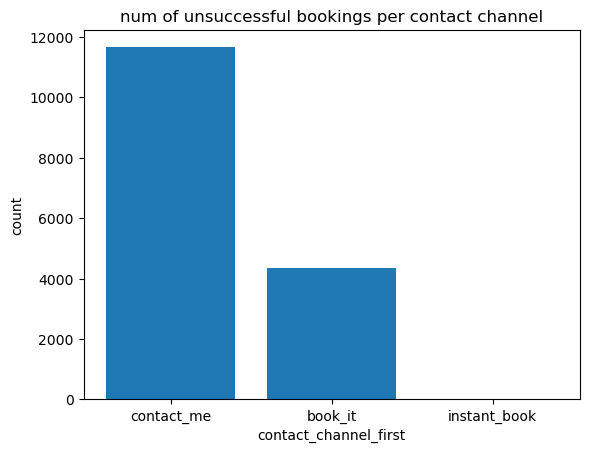

In [208]:
plt.bar(booking_contchannel_no['contact_channel_first'], booking_contchannel_no['count'])
plt.xlabel('contact_channel_first')
plt.ylabel('count')
plt.xticks(booking_contchannel_no['contact_channel_first'], ['contact_me', 'book_it','instant_book'])
plt.title('num of unsuccessful bookings per contact channel')
plt.show()


The graph shows the number of unsuccessful bookings per contact channel. As observed the majority of unsuccessful bookings are registered when using contact_me as a contact channel. In order to address this issue, Airbnb should  increase the number of hosts allowing their guests to book a room through instant_book, the most effective method. 

In [209]:
booking_contchannel_yes_rate = booking_contchannel_yes.copy()
booking_contchannel_no_rate = booking_contchannel_no.copy()
booking_contchannel_yes_rate['count'] = booking_contchannel_yes['count']/booking_contchannel_all['count']
booking_contchannel_no_rate['count'] = booking_contchannel_no['count']/booking_contchannel_all['count']

In [210]:
booking_contchannel_yes.head()

,contact_channel_first,count
1,contact_me,888
0,book_it,3842
2,instant_book,6683


In [211]:
booking_contchannel_no.head()

,contact_channel_first,count
1,contact_me,11650
0,book_it,4338
2,instant_book,0


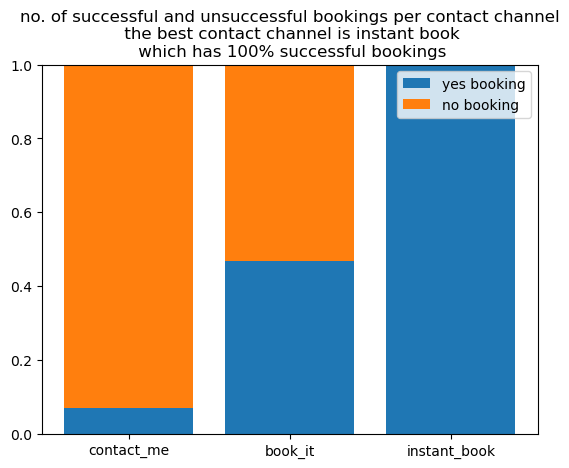

In [212]:
plt.bar(booking_contchannel_yes_rate['contact_channel_first'],booking_contchannel_yes_rate['count'])
plt.bar(booking_contchannel_no_rate['contact_channel_first'], booking_contchannel_no_rate['count'], bottom = booking_contchannel_yes_rate['count'])
plt.xticks(booking_contchannel_no_rate['contact_channel_first'], ['contact_me', 'book_it','instant_book'])
plt.title('no. of successful and unsuccessful bookings per contact channel\n the best contact channel is instant book\n which has 100% successful bookings')
plt.gca().legend(('yes booking','no booking'))
plt.show()
#100 stacked chart

In [213]:
reviews_contact = contacts_listings.groupby('contact_channel_first')['total_reviews'].sum().reset_index()
reviews_contact.head()

,contact_channel_first,total_reviews
0,book_it,124922.0
1,contact_me,117052.0
2,instant_book,185858.0


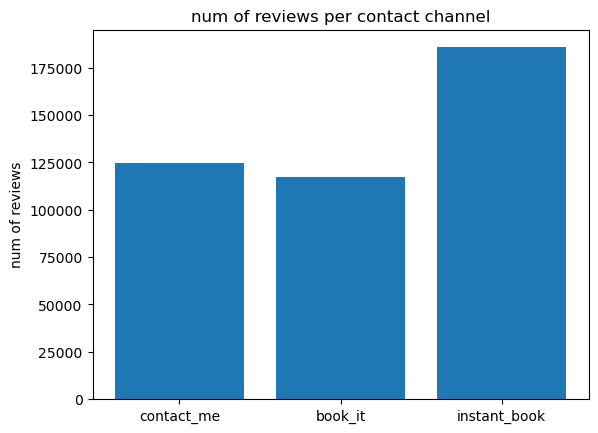

In [214]:
plt.bar(reviews_contact['contact_channel_first'],reviews_contact['total_reviews'])
plt.xticks(reviews_contact['contact_channel_first'], ['contact_me', 'book_it','instant_book'])
plt.title('num of reviews per contact channel')
plt.ylabel('num of reviews')
plt.show()

The graph shows the total amount of reviews per contact channel. Once again it is confirmed that the houses booked using instant book as a contact channel were the ones with the highest number of reviews, so they were the best ones. 

# Unsuccessful bookings rate

In [215]:
unbookings_rate = booking_contchannel_no['count'].sum()/booking_contchannel_all['count'].sum()*100
print('unsuccessful bookings rate:',unbookings_rate, '%')
unbookings_rate_cm = booking_contchannel_no.iloc[0]['count']/booking_contchannel_all.iloc[0]['count']*100
print('unsuccessful bookings rate:',unbookings_rate_cm, '%')
unbookings_rate_bi = booking_contchannel_no.iloc[1]['count']/booking_contchannel_all.iloc[1]['count']*100
print('unsuccessful bookings rate:',unbookings_rate_bi, '%')
unbookings_rate_ib = booking_contchannel_no.iloc[2]['count']/booking_contchannel_all.iloc[2]['count']*100
print('unsuccessful bookings rate:',unbookings_rate_ib, '%')

unsuccessful bookings rate: 58.34823546585891 %
unsuccessful bookings rate: 92.91753070665177 %
unsuccessful bookings rate: 53.03178484107579 %
unsuccessful bookings rate: 0.0 %


In [216]:
unbookings_rate_df = contacts_listings.copy()
unbookings_rate_df['week'] = contacts_listings['ts_interaction_first'].dt.to_period('W').apply(lambda r: r.start_time)
unbookings_rate_df.sort_values(by = 'week', inplace = True)
unbookings_rate_df = unbookings_rate_df.groupby('week').agg(
    yes = ('booked', 'sum'),
    no = ('booked', lambda x: (~x).sum())
).reset_index()
unbookings_rate_df.head()

,week,yes,no
0,2015-12-28,144,302
1,2016-01-04,530,1574
2,2016-01-11,488,1392
3,2016-01-18,508,1150
4,2016-01-25,437,952


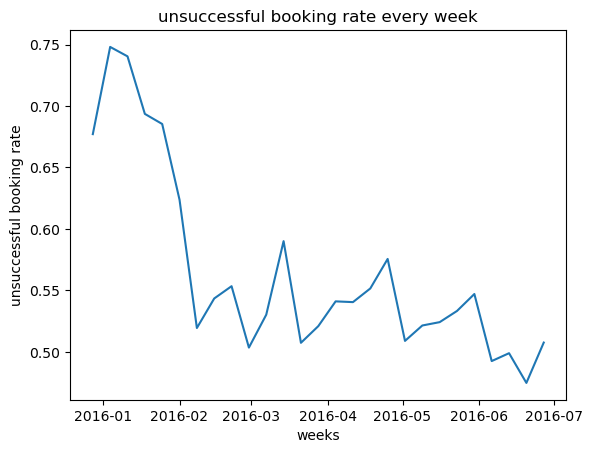

In [217]:
plt.plot(unbookings_rate_df['week'],unbookings_rate_df['no']/(unbookings_rate_df['no'] + unbookings_rate_df['yes']))
plt.title('unsuccessful booking rate every week')
plt.xlabel('weeks')
plt.ylabel('unsuccessful booking rate')
plt.show()

As shown by the graph the number of unsuccessful bookings decreased throughout the weeks in 2016, showing that Airbnb should have improved its strategies to avoid cancellations. 

In [218]:
contacts_listings_dummies['booked'] = contacts_listings_dummies['ts_booking_at'].notna()
contacts_listings_dummies['diff_reply_interaction'] = contacts_listings_dummies['ts_reply_at_first']- contacts_listings_dummies['ts_interaction_first']
contacts_listings_dummies['time_of_booking'] = contacts_listings_dummies['ts_booking_at']- contacts_listings_dummies['ts_accepted_at_first']
contacts_listings_dummies['hour'] = contacts_listings_dummies['ts_interaction_first'].dt.hour
contacts_listings_cm = contacts_listings_dummies.copy()
contacts_listings_cm['ts_interaction_first'] = contacts_listings_cm['ts_interaction_first'].apply(lambda x : x.timestamp())
contacts_listings_cm['ts_reply_at_first'] = contacts_listings_cm['ts_reply_at_first'].apply(lambda x : x.timestamp() if pd.notna(x) else None)
contacts_listings_cm['ts_accepted_at_first'] = contacts_listings_cm['ts_accepted_at_first'].apply(lambda x : x.timestamp() if pd.notna(x) else None) 
contacts_listings_cm['ts_booking_at'] = contacts_listings_cm['ts_booking_at'].apply(lambda x : x.timestamp() if pd.notna(x) else None)
contacts_listings_cm['ds_checkin_first'] = contacts_listings_cm['ds_checkin_first'].apply(lambda x : x.timestamp()if pd.notna(x) else None)
contacts_listings_cm['ds_checkout_first'] = contacts_listings_cm['ds_checkout_first'].apply(lambda x : x.timestamp()if pd.notna(x) else None)
correlation_matrix = contacts_listings_dummies.corr()
booked_corr = correlation_matrix['booked']
booked_corr.drop('booked')

index                                  -0.124044
ts_interaction_first                    0.146602
ts_reply_at_first                       0.239138
ts_accepted_at_first                    0.712064
ts_booking_at                           1.000000
ds_checkin_first                       -0.072265
ds_checkout_first                      -0.092354
m_guests                               -0.127519
m_interactions                          0.412696
m_first_message_length_in_characters   -0.110212
total_reviews                           0.293645
diff_reply_interaction                  0.238912
time_of_booking                         1.000000
hour                                    0.000658
contact_channel_first_book_it           0.070353
contact_channel_first_contact_me       -0.644052
contact_channel_first_instant_book      0.672216
guest_user_stage_first_new             -0.195090
guest_user_stage_first_past_booker      0.195090
room_type_Entire home/apt              -0.049992
room_type_Private ro

The objective here is to find the correlation between the variable booked and different features. As observed the ones influencing booked the most are ts_interaction_first (12%), ts_reply_at_first (23%), ts_accepted_at_first (71%), m_guests (-12%), m_interactions (41%), m_first_message_length_in_characters (- 11%), total_reviews (29%), time_of_reply (23%), contact_channel_first_book_it (even though the correlation is low must be taken into account since I'm considering the other two contact channels), contact_channel_first_contact_me (- 64%), contact_channel_first_instant_book (67%), guest_user_stage_first_new (- 19%) and guest_user_stage_first_past_booker (19%). 

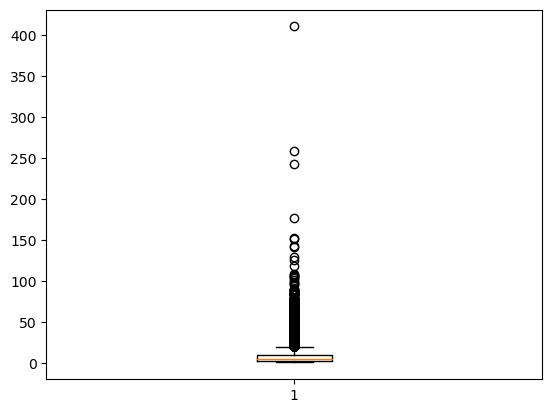

In [219]:
plt.boxplot(contacts_listings_dummies['m_interactions'])
plt.show()

In [220]:
q1 = contacts_listings_dummies['m_interactions'].quantile(0.1)
q2 = contacts_listings_dummies['m_interactions'].quantile(0.9)
iqr = q2 - q1
lb = q1 - 1.5 * iqr
ub = q2 + 1.5 * iqr
contacts_listings_dummies = contacts_listings_dummies[(contacts_listings_dummies['m_interactions'] >= lb) & (contacts_listings_dummies['m_interactions'] <= ub)]

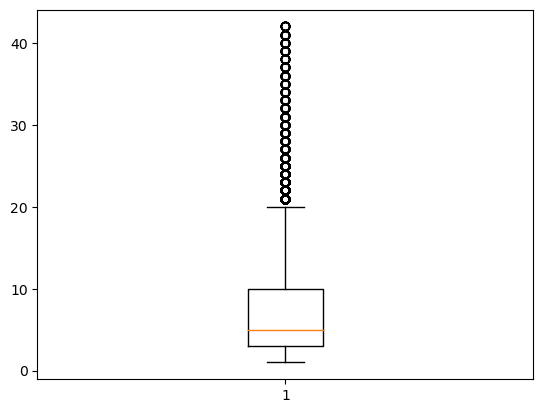

In [221]:
plt.boxplot(contacts_listings_dummies['m_interactions'])
plt.show()

In [222]:
m_interaction_bins = [0,10,20,30,40,50]
m_interaction_labels = ['0-10','11-20','21-30','31-40','41+']
contacts_listings['interactions_binned'] = pd.cut(contacts_listings['m_interactions'], bins = m_interaction_bins, labels = m_interaction_labels, right = True)
df_interactions = contacts_listings.groupby(['interactions_binned','booked'])['m_guests'].count().reset_index(name = 'count')
df_interactions.head()

,interactions_binned,booked,count
0,0-10,False,14832
1,0-10,True,6084
2,11-20,False,875
3,11-20,True,3408
4,21-30,False,171


In [223]:
df_interactions_t = df_interactions[df_interactions['booked'] == True]
df_interactions_f = df_interactions[df_interactions['booked'] == False]

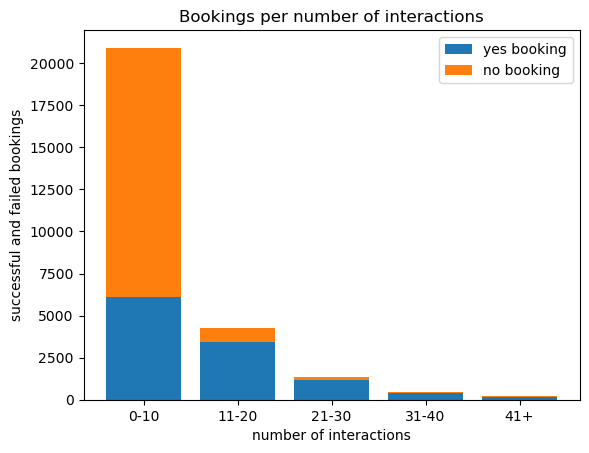

In [224]:
plt.bar(df_interactions_t['interactions_binned'],df_interactions_t['count'])
plt.bar(df_interactions_f['interactions_binned'], df_interactions_f['count'], bottom = df_interactions_t['count'])
plt.xticks(df_interactions_t['interactions_binned'], df_interactions_t['interactions_binned'])
plt.title('Bookings per number of interactions')
plt.xlabel('number of interactions')
plt.ylabel('successful and failed bookings')
plt.gca().legend(('yes booking','no booking'))
plt.show()

In [225]:
contacts_listings_rt_mg = contacts_listings.groupby('room_type')['m_guests'].mean().reset_index()
contacts_listings_rt_mg.head()

,room_type,m_guests
0,Entire home/apt,3.126068
1,Private room,1.694252
2,Shared room,2.140893


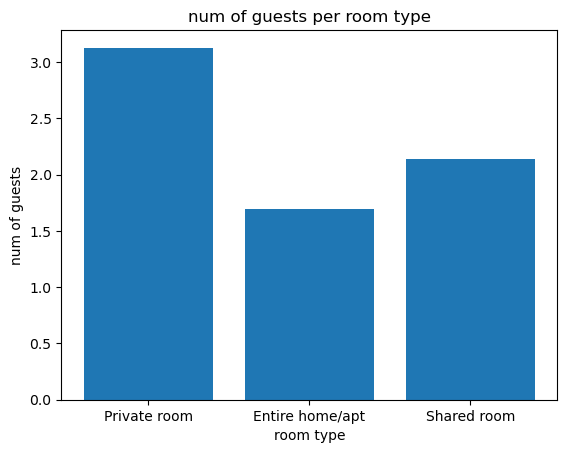

In [226]:
plt.bar(contacts_listings_rt_mg['room_type'],contacts_listings_rt_mg['m_guests'])
plt.xticks(contacts_listings_rt_mg['room_type'], ['Private room','Entire home/apt','Shared room'])
plt.xlabel('room type')
plt.ylabel('num of guests')
plt.title('num of guests per room type')
plt.show()

In [227]:
X = contacts_listings_dummies[['ts_interaction_first','m_guests','m_first_message_length_in_characters','m_interactions','total_reviews','contact_channel_first_book_it','contact_channel_first_contact_me','contact_channel_first_instant_book','guest_user_stage_first_new','guest_user_stage_first_past_booker']]
X['ts_interaction_first'] = X['ts_interaction_first'].apply(lambda x : x.timestamp())

y = contacts_listings_dummies['booked'].map({True:1,False:0})
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state = int(round(time.time())))


# Initialize and train classifier
model = RandomForestClassifier(n_estimators=100, random_state= int(round(time.time())))
model.fit(X_train, y_train)


# Predictions
y_pred = model.predict(X_test)

# Evaluation
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

/var/folders/l4/wk91r91d5_z6f3bpr70jqh240000gn/T/ipykernel_17035/1536375938.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['ts_interaction_first'] = X['ts_interaction_first'].apply(lambda x : x.timestamp())


Accuracy: 0.9149408284023669


In [228]:
cm_2 = confusion_matrix(y_test,y_pred)
tn, fp, fn, tp = confusion_matrix(y_test,y_pred).ravel()
print('true negative', tn)
print('false positive', fp)
print('false negative', fn)
print('true positive', tp)

true negative 2953
false positive 198
false negative 262
true positive 1995


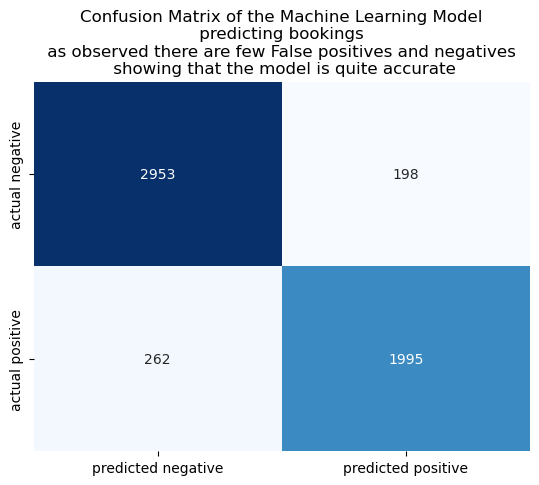

In [229]:
df_cm_attempt_2 = pd.DataFrame(cm_2,index = ['actual negative','actual positive'], columns = ['predicted negative', 'predicted positive'])
sns.heatmap(df_cm_attempt_2, annot = True, fmt = 'd',cmap = 'Blues', cbar = False)
plt.title('Confusion Matrix of the Machine Learning Model\n predicting bookings \n as observed there are few False positives and negatives \n showing that the model is quite accurate')
plt.show()

# Average Response Time

In [230]:
contacts_no_ib = contacts_listings[contacts_listings['contact_channel_first'] != 'instant_book']
contacts_no_ib.dropna(subset = ['ts_reply_at_first'], inplace = True)
contacts_no_ib.head()
#I decided to exclude instant_book, since the average response time is less than 1 minute

/var/folders/l4/wk91r91d5_z6f3bpr70jqh240000gn/T/ipykernel_17035/3210914869.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  contacts_no_ib.dropna(subset = ['ts_reply_at_first'], inplace = True)


,id_guest_anon,id_host_anon,id_listing_anon,ts_interaction_first,ts_reply_at_first,ts_accepted_at_first,ts_booking_at,ds_checkin_first,ds_checkout_first,m_guests,...,contact_channel_first,guest_user_stage_first,room_type,listing_neighborhood,total_reviews,booked,diff_reply_interaction,time_of_booking,hour,interactions_binned
0,da8656a1-51af-4f38-b1c4-94be1f585157,5426897d-960d-4013-9e38-606ae746793c,a408a8b2-0d44-4513-a611-3736d0409bb2,2016-04-21 02:55:53,2016-04-21 03:15:00,2016-04-21 03:15:00,2016-04-21 03:15:00,2016-08-02,2016-08-06,4.0,...,book_it,past_booker,Entire home/apt,Copacabana,9.0,True,0 days 00:19:07,0 days,2,21-30
1,8590d6f1-8bc9-4e8b-bdfb-de78f69fcf37,f30417c5-6df4-45ac-bfc2-6ad1cce398ab,e387c705-0aeb-464c-9375-ece63be6f006,2016-02-16 22:14:01,2016-02-16 23:37:36,NaT,NaT,2016-08-11,2016-08-22,5.0,...,contact_me,past_booker,Entire home/apt,Copacabana,0.0,False,0 days 01:23:35,NaT,22,0-10
2,ebcd83ba-bda1-47eb-9680-2dd04ccf3988,13cbf50a-3272-45d4-9866-a06b6ea1b99a,d1eb1960-938f-4305-a353-51e224414dd4,2016-01-27 23:33:38,2016-01-28 02:12:47,NaT,NaT,2016-03-14,2016-03-23,1.0,...,contact_me,new,Private room,Vidigal,49.0,False,0 days 02:39:09,NaT,23,0-10
3,3b6d161c-0451-4e71-9896-026e2503dc38,13cbf50a-3272-45d4-9866-a06b6ea1b99a,d1eb1960-938f-4305-a353-51e224414dd4,2016-05-23 12:37:44,2016-05-23 13:12:10,NaT,NaT,2016-06-11,2016-06-17,1.0,...,contact_me,past_booker,Private room,Vidigal,49.0,False,0 days 00:34:26,NaT,12,11-20
6,968d1d0e-8ace-4e9b-b806-7a4ae3dafbd5,13cbf50a-3272-45d4-9866-a06b6ea1b99a,d1eb1960-938f-4305-a353-51e224414dd4,2016-03-21 22:32:01,2016-03-21 22:39:02,2016-03-21 22:40:26,NaT,2016-03-25,2016-03-27,2.0,...,contact_me,past_booker,Private room,Vidigal,49.0,False,0 days 00:07:01,NaT,22,0-10


In [231]:
contacts_no_ib['diff_reply_interaction'].isna().sum()
contacts_no_ib['diff_reply_interaction'].describe().reset_index()

,index,diff_reply_interaction
0,count,18689
1,mean,0 days 19:55:13.997966718
2,std,6 days 18:22:42.549460484
3,min,0 days 00:00:00
4,25%,0 days 00:24:52
5,50%,0 days 02:32:25
6,75%,0 days 10:45:39
7,max,410 days 02:55:54


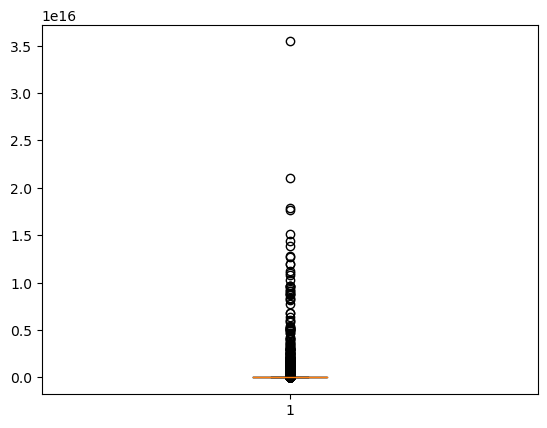

In [232]:
plt.boxplot(contacts_no_ib['diff_reply_interaction'])
plt.show()

In [233]:
q1 = contacts_no_ib['diff_reply_interaction'].quantile(0.1)
q2 = contacts_no_ib['diff_reply_interaction'].quantile(0.9)
iqr = q2 - q1
lb = q1 - 1.5 * iqr
ub = q2 + 1.5 * iqr
contacts_no_ib = contacts_no_ib[(contacts_no_ib['diff_reply_interaction'] >= lb) & (contacts_no_ib['diff_reply_interaction'] <= ub)]

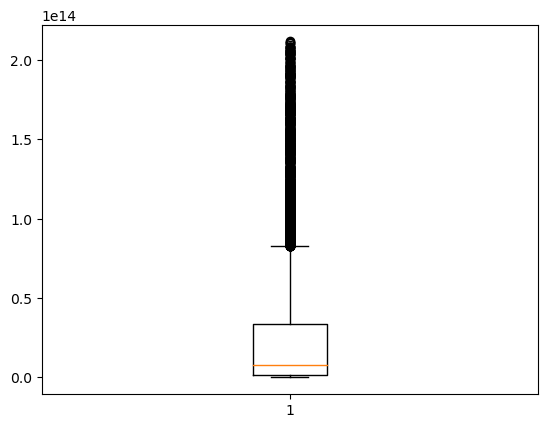

In [234]:
plt.boxplot(contacts_no_ib['diff_reply_interaction'])
plt.show()

In [235]:
contacts_listings['hour'] = contacts_listings['ts_interaction_first'].dt.hour
contacts_cm = contacts_listings[contacts_listings['contact_channel_first'] == 'contact_me']
contacts_bi = contacts_listings[contacts_listings['contact_channel_first'] == 'book_it']
contacts_ib = contacts_listings[contacts_listings['contact_channel_first'] == 'instant_book']
hourly_counts_cm = contacts_cm['hour'].value_counts().sort_index()
hourly_counts_bi = contacts_bi['hour'].value_counts().sort_index()
hourly_counts_ib = contacts_ib['hour'].value_counts().sort_index()

In [236]:
print('average response time for contact_me:', contacts_cm['diff_reply_interaction'].mean())
print('average response time for book it:', contacts_bi['diff_reply_interaction'].mean())
print('average response time for instant book:', contacts_ib['diff_reply_interaction'].mean())

average response time for contact_me: 0 days 23:45:33.591960594
average response time for book it: 0 days 13:57:30.205054644
average response time for instant book: 0 days 01:23:05.658985485


In [237]:
avg_time_of_reply = contacts_listings.copy()
avg_time_of_reply['week'] = contacts_listings['ts_interaction_first'].dt.to_period('W').apply(lambda r: r.start_time)
avg_time_of_reply.sort_values(by = 'week', inplace = True)
avg_time_of_reply = avg_time_of_reply.groupby('week').agg(
    avg_time = ('diff_reply_interaction', 'mean')
).reset_index()
avg_time_of_reply.head()

,week,avg_time
0,2015-12-28,1 days 11:34:46.567088607
1,2016-01-04,1 days 03:41:13.200543478
2,2016-01-11,0 days 10:49:04.364761343
3,2016-01-18,0 days 14:15:13.733155436
4,2016-01-25,0 days 17:49:00.404323458


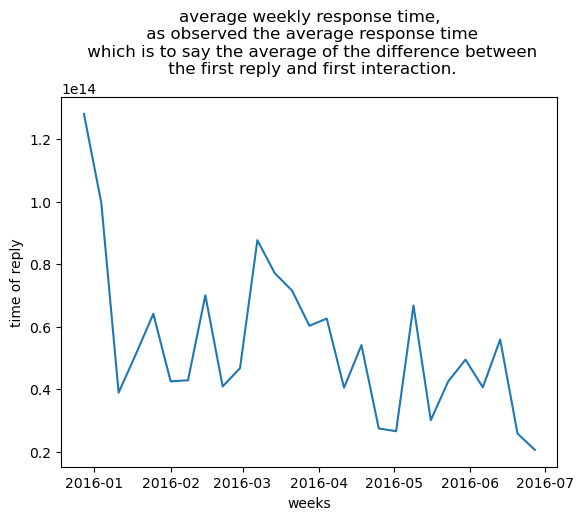

In [238]:
plt.plot(avg_time_of_reply['week'],avg_time_of_reply['avg_time'])
plt.title('average weekly response time,\n as observed the average response time\n which is to say the average of the difference between\n the first reply and first interaction.')
plt.xlabel('weeks')
plt.ylabel('time of reply')
plt.show()

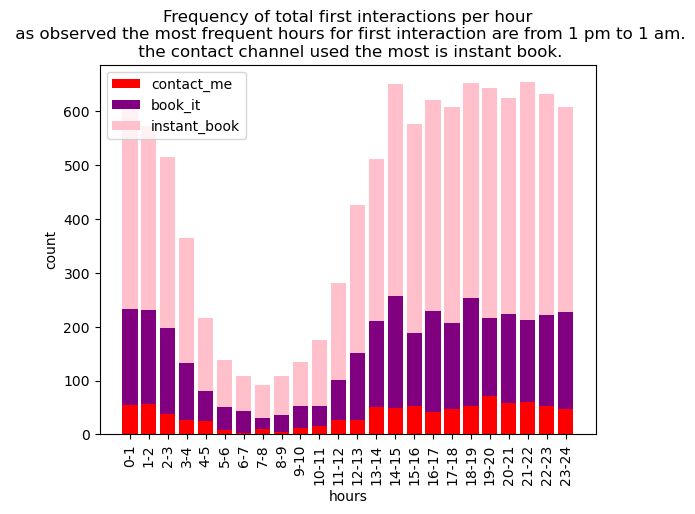

In [239]:
contacts_cm = contacts_cm[contacts_cm['booked']== True]
contacts_bi = contacts_bi[contacts_bi['booked']== True]
contacts_ib = contacts_ib[contacts_ib['booked']== True]
hourly_counts_cm = contacts_cm['hour'].value_counts().sort_index()
hourly_counts_bi = contacts_bi['hour'].value_counts().sort_index()
hourly_counts_ib = contacts_ib['hour'].value_counts().sort_index()
hours = []
for i in range(24):
    hours.append(f'{i}-{i+1}')
plt.bar(hourly_counts_cm.index,hourly_counts_cm.values, color = 'red')
plt.bar(hourly_counts_bi.index,hourly_counts_bi.values, bottom = hourly_counts_cm.values, color = 'purple')
plt.bar(hourly_counts_ib.index,hourly_counts_ib.values, bottom = hourly_counts_bi.values, color = 'pink')
plt.title('Frequency of total first interactions per hour\n as observed the most frequent hours for first interaction are from 1 pm to 1 am.\n the contact channel used the most is instant book.')
plt.xlabel('hours')
plt.ylabel('count')
plt.xticks(hourly_counts_cm.index, hours, rotation = 'vertical')
plt.gca().legend(('contact_me','book_it','instant_book'))

plt.show()

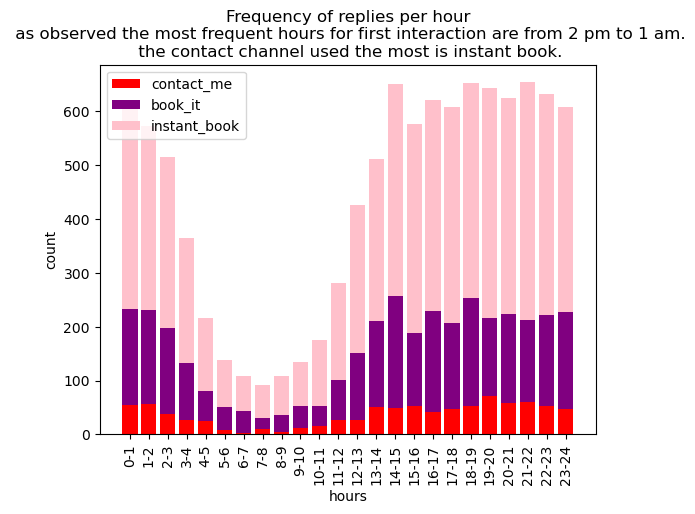

In [240]:
contacts_cm = contacts_cm[contacts_cm['booked']== True]
contacts_bi = contacts_bi[contacts_bi['booked']== True]
contacts_ib = contacts_ib[contacts_ib['booked']== True]
hourly_counts_cm = contacts_cm['hour'].value_counts().sort_index()
hourly_counts_bi = contacts_bi['hour'].value_counts().sort_index()
hourly_counts_ib = contacts_ib['hour'].value_counts().sort_index()
hours = []
for i in range(24):
    hours.append(f'{i}-{i+1}')
plt.bar(hourly_counts_cm.index,hourly_counts_cm.values, color = 'red')
plt.bar(hourly_counts_bi.index,hourly_counts_bi.values, bottom = hourly_counts_cm.values, color = 'purple')
plt.bar(hourly_counts_ib.index,hourly_counts_ib.values, bottom = hourly_counts_bi.values, color = 'pink')
plt.xticks(hourly_counts_cm.index, hours, rotation = 'vertical')
plt.title('Frequency of replies per hour\n as observed the most frequent hours for first interaction are from 2 pm to 1 am.\n the contact channel used the most is instant book.')
plt.xlabel('hours')
plt.ylabel('count')
plt.gca().legend(('contact_me','book_it','instant_book'))
plt.show()

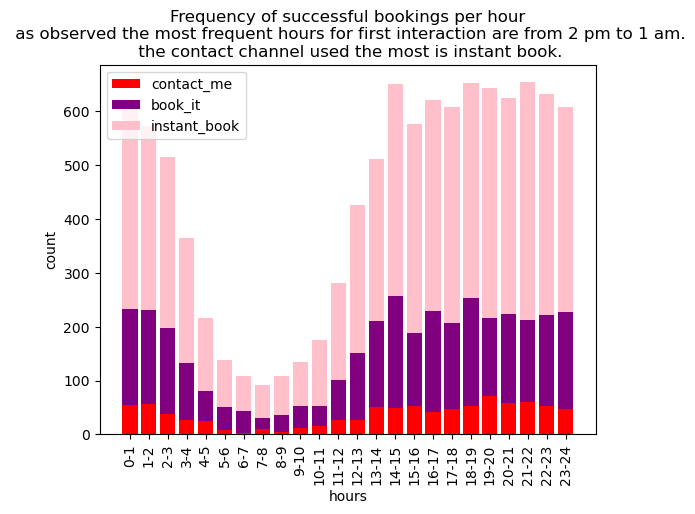

In [241]:
hourly_counts_cm_r = contacts_cm[contacts_cm['ts_reply_at_first'].notna()]['hour'].value_counts().sort_index()
hourly_counts_bi_r = contacts_bi[contacts_bi['ts_reply_at_first'].notna()]['hour'].value_counts().sort_index()
hourly_counts_ib_r = contacts_ib[contacts_ib['ts_reply_at_first'].notna()]['hour'].value_counts().sort_index()
hours = []
for i in range(24):
    hours.append(f'{i}-{i+1}')
plt.bar(hourly_counts_cm_r.index,hourly_counts_cm_r.values, color = 'red')
plt.bar(hourly_counts_bi_r.index,hourly_counts_bi_r.values, bottom = hourly_counts_cm_r.values, color = 'purple')
plt.bar(hourly_counts_ib_r.index,hourly_counts_ib_r.values, bottom = hourly_counts_bi_r.values, color = 'pink')
plt.xticks(hourly_counts_cm_r.index, hours, rotation = 'vertical')
plt.title('Frequency of successful bookings per hour\n as observed the most frequent hours for first interaction are from 2 pm to 1 am.\n the contact channel used the most is instant book.')
plt.xlabel('hours')
plt.ylabel('count')
plt.gca().legend(('contact_me','book_it','instant_book'))
plt.show()

In [242]:
response_time = contacts_listings[contacts_listings['booked'] == True]
response_time_cm = response_time[response_time['contact_channel_first']== 'contact_me']
response_time_bi = response_time[response_time['contact_channel_first']== 'book_it']
response_time_ib = response_time[response_time['contact_channel_first']== 'instant_book']
print('the best average response time for contact me is:',response_time_cm['diff_reply_interaction'].mean())
print('the best average response time for book it is:',response_time_bi['diff_reply_interaction'].mean())
print('the best average response time for instant book is:',response_time_ib['diff_reply_interaction'].mean())

the best average response time for contact me is: 0 days 04:42:00.889639639
the best average response time for book it is: 0 days 05:15:35.588755856
the best average response time for instant book is: 0 days 01:23:05.658985485


# Repeat Guest Rate

In [243]:
guest_user_stage_first_gb = contacts_listings.groupby(['guest_user_stage_first', 'booked']).size().reset_index(name = 'size')
guest_user_stage_first_gb.head()

,guest_user_stage_first,booked,size
0,new,False,10446
1,new,True,5222
2,past_booker,False,5542
3,past_booker,True,6191


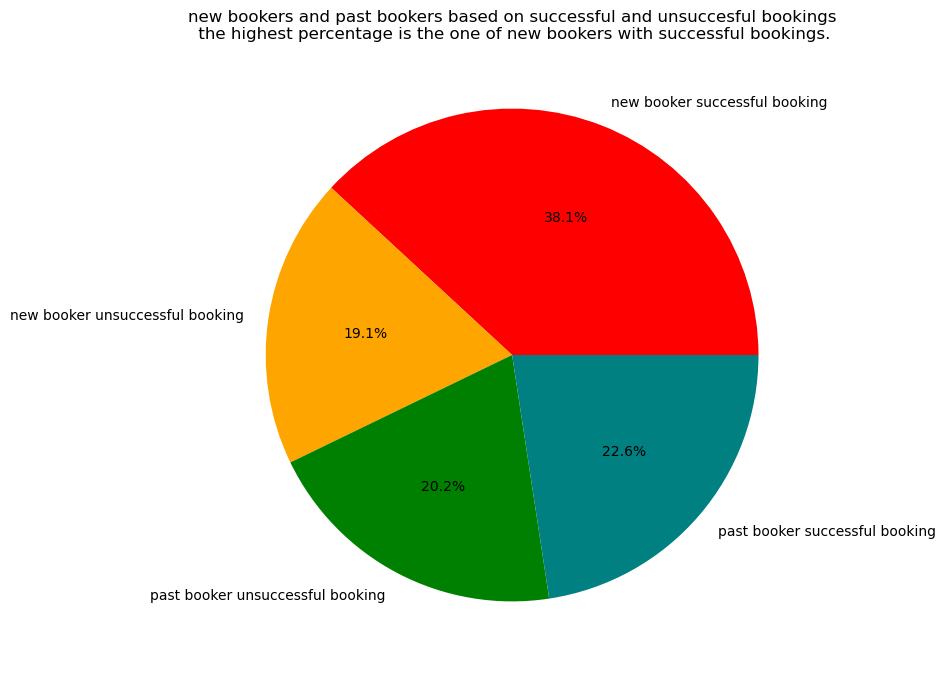

In [244]:
plt.figure(figsize = (20,8))
plt.pie(guest_user_stage_first_gb['size'], autopct = '%1.1f%%', labels = ['new booker successful booking','new booker unsuccessful booking','past booker unsuccessful booking','past booker successful booking'], colors = ['red', 'orange', 'green', 'teal'])
plt.title('new bookers and past bookers based on successful and unsuccesful bookings\n the highest percentage is the one of new bookers with successful bookings.')
plt.show()
#find different names that reflect definition

In [245]:
contacts_listings_dummies_2 = pd.get_dummies(contacts_listings,columns = ['contact_channel_first','guest_user_stage_first','room_type'])
contacts_listings_user_dummies = contacts_listings_dummies_2.merge(users, on = 'id_guest_anon')
contacts_listings_user_dummies.head()

,id_guest_anon,id_host_anon,id_listing_anon,ts_interaction_first,ts_reply_at_first,ts_accepted_at_first,ts_booking_at,ds_checkin_first,ds_checkout_first,m_guests,...,contact_channel_first_book_it,contact_channel_first_contact_me,contact_channel_first_instant_book,guest_user_stage_first_new,guest_user_stage_first_past_booker,room_type_Entire home/apt,room_type_Private room,room_type_Shared room,country,words_in_user_profile
0,da8656a1-51af-4f38-b1c4-94be1f585157,5426897d-960d-4013-9e38-606ae746793c,a408a8b2-0d44-4513-a611-3736d0409bb2,2016-04-21 02:55:53,2016-04-21 03:15:00,2016-04-21 03:15:00,2016-04-21 03:15:00,2016-08-02,2016-08-06,4.0,...,True,False,False,False,True,True,False,False,CL,0
1,8590d6f1-8bc9-4e8b-bdfb-de78f69fcf37,f30417c5-6df4-45ac-bfc2-6ad1cce398ab,e387c705-0aeb-464c-9375-ece63be6f006,2016-02-16 22:14:01,2016-02-16 23:37:36,NaT,NaT,2016-08-11,2016-08-22,5.0,...,False,True,False,False,True,True,False,False,FR,0
2,ebcd83ba-bda1-47eb-9680-2dd04ccf3988,13cbf50a-3272-45d4-9866-a06b6ea1b99a,d1eb1960-938f-4305-a353-51e224414dd4,2016-01-27 23:33:38,2016-01-28 02:12:47,NaT,NaT,2016-03-14,2016-03-23,1.0,...,False,True,False,True,False,False,True,False,AR,0
3,3b6d161c-0451-4e71-9896-026e2503dc38,13cbf50a-3272-45d4-9866-a06b6ea1b99a,d1eb1960-938f-4305-a353-51e224414dd4,2016-05-23 12:37:44,2016-05-23 13:12:10,NaT,NaT,2016-06-11,2016-06-17,1.0,...,False,True,False,False,True,False,True,False,IT,26
4,87e3f72d-c63e-4410-b681-aea758c72116,13cbf50a-3272-45d4-9866-a06b6ea1b99a,d1eb1960-938f-4305-a353-51e224414dd4,2016-05-29 21:39:16,2016-05-29 21:39:16,2016-05-29 21:39:16,2016-05-29 21:39:16,2016-06-03,2016-06-04,1.0,...,False,False,True,False,True,False,True,False,FR,0


In [246]:
users_country = contacts_listings_user_dummies.groupby('country')['id_guest_anon'].count().reset_index()
users_country = users_country[users_country['id_guest_anon']> 50][users_country['country'] != 'BR']
len(users_country)
users_country.head()

/var/folders/l4/wk91r91d5_z6f3bpr70jqh240000gn/T/ipykernel_17035/3410228256.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  users_country = users_country[users_country['id_guest_anon']> 50][users_country['country'] != 'BR']


,country,id_guest_anon
2,AR,2290
3,AT,60
4,AU,443
10,BE,110
18,CA,438


In [247]:
contacts_listings_user_dummies_2 = contacts_listings_user_dummies[contacts_listings_user_dummies['country'].isin(users_country['country'])]
users_country_new = contacts_listings_user_dummies_2.groupby('country')['guest_user_stage_first_new'].sum().reset_index(name = 'count')
users_country_past =contacts_listings_user_dummies_2.groupby('country')['guest_user_stage_first_past_booker'].sum().reset_index(name = 'count')
users_country_new.head()

,country,count
0,AR,1600
1,AT,21
2,AU,162
3,BE,44
4,CA,170


In [248]:
users_country_past.head()

,country,count
0,AR,690
1,AT,39
2,AU,281
3,BE,66
4,CA,268


In [249]:
country_ratio = users_country_new.merge(users_country_past, on = 'country')
country_ratio['ratio_x'] = country_ratio['count_x']/(country_ratio['count_x']+ country_ratio['count_y'])
country_ratio['ratio_y'] = country_ratio['count_y']/(country_ratio['count_x']+ country_ratio['count_y'])
country_ratio.head()

,country,count_x,count_y,ratio_x,ratio_y
0,AR,1600,690,0.698690,0.301310
1,AT,21,39,0.350000,0.650000
2,AU,162,281,0.365688,0.634312
3,BE,44,66,0.400000,0.600000
4,CA,170,268,0.388128,0.611872


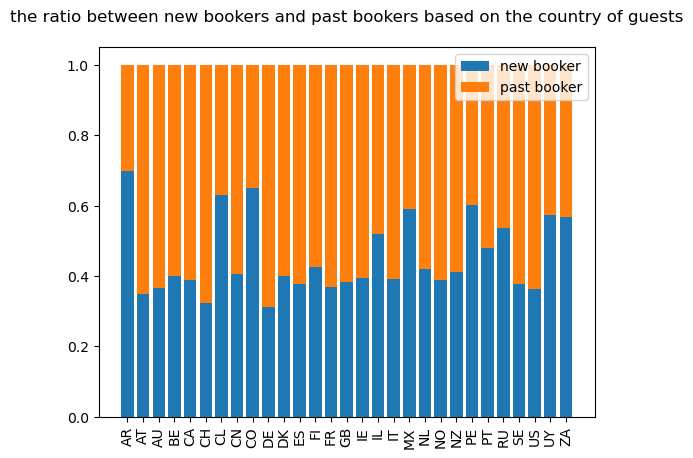

In [250]:
plt.bar(country_ratio['country'],country_ratio['ratio_x'])
plt.bar(country_ratio['country'],country_ratio['ratio_y'], bottom = country_ratio['ratio_x'])
plt.xticks(users_country_new['country'], rotation = 'vertical')
plt.gca().legend(('new booker','past booker'))
plt.title('the ratio between new bookers and past bookers based on the country of guests\n')
plt.show()

In [251]:
past_booker = contacts_listings[contacts_listings['guest_user_stage_first'] == 'past_booker']
past_booker = past_booker[past_booker['booked'] == True]
new_booker = contacts_listings[contacts_listings['guest_user_stage_first'] == 'new']
new_booker = new_booker[new_booker['booked'] == True]

In [252]:
past_booker = past_booker.groupby('contact_channel_first')['guest_user_stage_first'].count().reset_index(name = 'count')
new_booker = new_booker.groupby('contact_channel_first')['guest_user_stage_first'].count().reset_index(name = 'count')
past_booker.head()

,contact_channel_first,count
0,book_it,1947
1,contact_me,363
2,instant_book,3881


In [253]:
new_booker.head()

,contact_channel_first,count
0,book_it,1895
1,contact_me,525
2,instant_book,2802


In [254]:
past_new_booker = past_booker.merge(new_booker, on = 'contact_channel_first')
past_new_booker['ratio_x'] = past_new_booker['count_x']/(past_new_booker['count_x']+ past_new_booker['count_y'])
past_new_booker['ratio_y'] = past_new_booker['count_y']/(past_new_booker['count_x']+ past_new_booker['count_y'])
past_new_booker.head()

,contact_channel_first,count_x,count_y,ratio_x,ratio_y
0,book_it,1947,1895,0.506767,0.493233
1,contact_me,363,525,0.408784,0.591216
2,instant_book,3881,2802,0.580727,0.419273


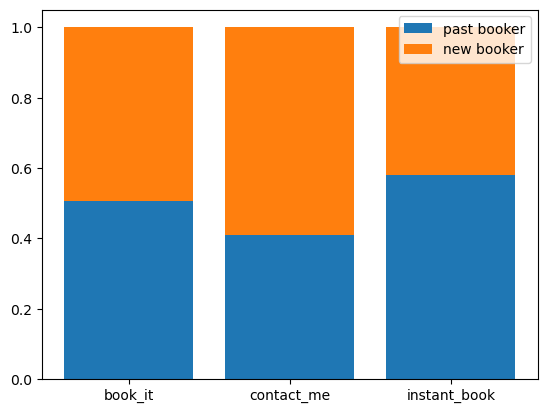

In [255]:
plt.bar(past_new_booker['contact_channel_first'],past_new_booker['ratio_x'])
plt.bar(past_new_booker['contact_channel_first'],past_new_booker['ratio_y'], bottom = past_new_booker['ratio_x'])
plt.xticks(past_new_booker['contact_channel_first'])
plt.gca().legend(('past booker','new booker'))
plt.show()

In [256]:
contacts_listings_user_dummies['booked'] = contacts_listings_user_dummies['ts_booking_at'].notna()

In [257]:
avg_past_bookers = contacts_listings_user_dummies.copy()
avg_past_bookers = avg_past_bookers[avg_past_bookers['booked'] == True]
avg_past_bookers['week'] = contacts_listings_user_dummies['ts_interaction_first'].dt.to_period('W').apply(lambda r: r.start_time)
avg_past_bookers.sort_values(by = 'week', inplace = True)
avg_past_bookers = avg_past_bookers.groupby('week').agg(
    avg_past = ('guest_user_stage_first_past_booker', 'sum')
).reset_index()
avg_past_bookers.head()

,week,avg_past
0,2015-12-28,89
1,2016-01-04,298
2,2016-01-11,260
3,2016-01-18,254
4,2016-01-25,236


In [258]:
avg_new_bookers = contacts_listings_user_dummies.copy()
avg_new_bookers = avg_new_bookers[avg_new_bookers['booked'] == True]
avg_new_bookers['week'] = contacts_listings_user_dummies['ts_interaction_first'].dt.to_period('W').apply(lambda r: r.start_time)
avg_new_bookers.sort_values(by = 'week', inplace = True)
avg_new_bookers = avg_new_bookers.groupby('week').agg(
    avg_new = ('guest_user_stage_first_new', 'sum')
).reset_index()
avg_new_bookers.head()

,week,avg_new
0,2015-12-28,55
1,2016-01-04,232
2,2016-01-11,228
3,2016-01-18,254
4,2016-01-25,201


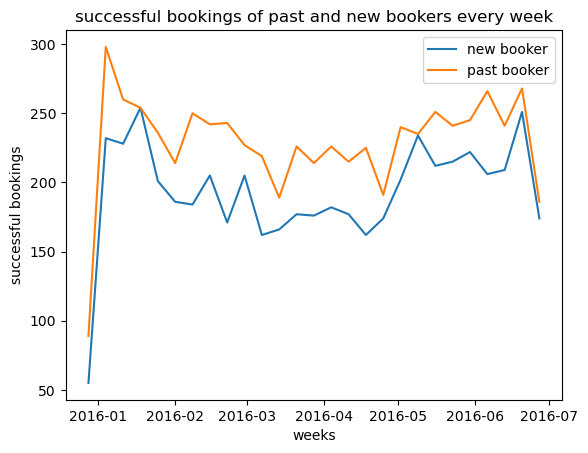

In [259]:
plt.plot(avg_new_bookers['week'],avg_new_bookers['avg_new'])
plt.plot(avg_past_bookers['week'],avg_past_bookers['avg_past'])
plt.title('successful bookings of past and new bookers every week')
plt.xlabel('weeks')
plt.ylabel('successful bookings')
plt.gca().legend(('new booker','past booker'))
plt.show()

In [260]:
repeat_guest_rate = contacts_listings[contacts_listings['booked'] == True]
repeat_guest_rate_past = repeat_guest_rate[repeat_guest_rate['guest_user_stage_first'] == 'past_booker']
repeat_guest_rate = repeat_guest_rate.groupby('booked')['guest_user_stage_first'].count().reset_index(name = 'count')
repeat_guest_rate_past = repeat_guest_rate_past.groupby('booked')['guest_user_stage_first'].count().reset_index(name = 'count')
repeat_guest_rate['count'] = repeat_guest_rate_past['count'].sum()/repeat_guest_rate['count'].sum()*100
print('the repeat guest rate is:',float(repeat_guest_rate['count'].round(2)), '%')

the repeat guest rate is: 54.25 %


/var/folders/l4/wk91r91d5_z6f3bpr70jqh240000gn/T/ipykernel_17035/1111363379.py:6: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  print('the repeat guest rate is:',float(repeat_guest_rate['count'].round(2)), '%')


# Areas where airbnb should invest in Rio de Janeiro

In [261]:
contacts_listings = contacts_listings[contacts_listings['listing_neighborhood']!= '-unknown-']
contacts_listings_t = contacts_listings[contacts_listings['booked'] == True]
contacts_listings_f = contacts_listings[contacts_listings['booked'] == False]

In [262]:
top_10_n = contacts_listings['listing_neighborhood'].value_counts().nlargest(30).index
top_10_n = contacts_listings[contacts_listings['listing_neighborhood'].isin(top_10_n)]
flop_10_n = contacts_listings['listing_neighborhood'].value_counts().nlargest(30).index
flop_10_n = contacts_listings[contacts_listings['listing_neighborhood'].isin(flop_10_n)]
top_10_n_t = contacts_listings_t['listing_neighborhood'].value_counts().nlargest(30).index
top_10_n_t=  contacts_listings_t[contacts_listings_t['listing_neighborhood'].isin(top_10_n_t)]
flop_10_n_t = contacts_listings_t['listing_neighborhood'].value_counts().nsmallest(30).index
flop_10_n_t = contacts_listings_t[contacts_listings_t['listing_neighborhood'].isin(flop_10_n_t)]
top_10_n_f = contacts_listings_f['listing_neighborhood'].value_counts().nlargest(30).index
top_10_n_f=  contacts_listings_f[contacts_listings_f['listing_neighborhood'].isin(top_10_n_f)]
flop_10_n_f = contacts_listings_f['listing_neighborhood'].value_counts().nsmallest(30).index
flop_10_n_f = contacts_listings_f[contacts_listings_f['listing_neighborhood'].isin(flop_10_n_f)]

In [263]:
top_10_n_cc_t = top_10_n_t.groupby('contact_channel_first')['listing_neighborhood'].count().reset_index(name = 'count')
top_10_n_cc_t.head()

,contact_channel_first,count
0,book_it,2385
1,contact_me,517
2,instant_book,4225


In [264]:
top_10_n_cc_f = top_10_n_f.groupby('contact_channel_first')['listing_neighborhood'].count().reset_index(name = 'count')
top_10_n_cc_f.loc[2] = ['instant_book',0]
top_10_n_cc_f.head()

,contact_channel_first,count
0,book_it,2396
1,contact_me,6089
2,instant_book,0


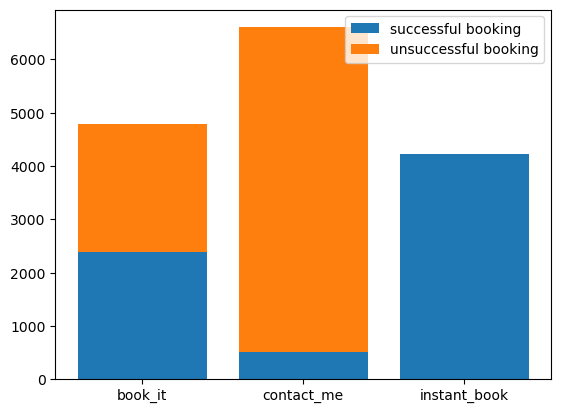

In [265]:
plt.bar(top_10_n_cc_t['contact_channel_first'],top_10_n_cc_t['count'])
plt.bar(top_10_n_cc_f['contact_channel_first'],top_10_n_cc_f['count'], bottom = top_10_n_cc_t['count'])
plt.xticks(top_10_n_cc_f['contact_channel_first'])
plt.gca().legend(('successful booking','unsuccessful booking'))
plt.show()

In [266]:
flop_10_n_cc_t = flop_10_n_t.groupby('contact_channel_first')['listing_neighborhood'].count().reset_index(name = 'count')
flop_10_n_cc_t.head()

,contact_channel_first,count
0,book_it,42
1,contact_me,14
2,instant_book,127


In [267]:
flop_10_n_cc_f = flop_10_n_f.groupby('contact_channel_first')['listing_neighborhood'].count().reset_index(name = 'count')
flop_10_n_cc_f.loc[2] = ['instant_book',0]
flop_10_n_cc_f.head()

,contact_channel_first,count
0,book_it,12
1,contact_me,53
2,instant_book,0


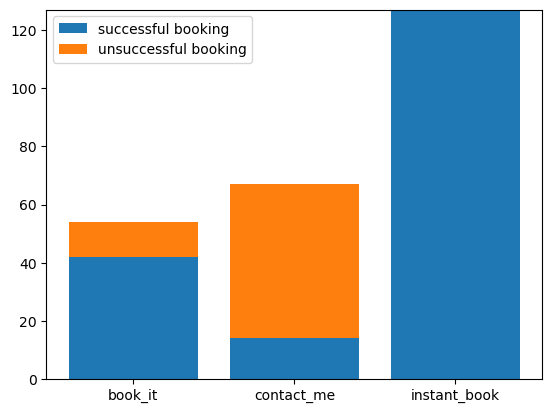

In [268]:
plt.bar(flop_10_n_cc_t['contact_channel_first'],flop_10_n_cc_t['count'])
plt.bar(flop_10_n_cc_f['contact_channel_first'],flop_10_n_cc_f['count'], bottom = flop_10_n_cc_t['count'])
plt.xticks(flop_10_n_cc_f['contact_channel_first'])
plt.gca().legend(('successful booking','unsuccessful booking'))
plt.show()

In [269]:
top_10_n_t_gusf = top_10_n_t.groupby('guest_user_stage_first')['listing_neighborhood'].count().reset_index(name = 'count')
flop_10_n_t_gusf = flop_10_n_t.groupby('guest_user_stage_first')['listing_neighborhood'].count().reset_index(name = 'count')
top_10_n_t_gusf.head()
#more past bookers than new bookers are coming back, so airbnb should invest in new bookers.

,guest_user_stage_first,count
0,new,3165
1,past_booker,3962


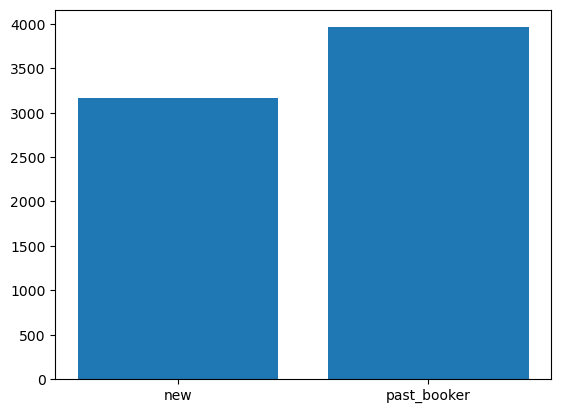

In [270]:
plt.bar(top_10_n_t_gusf['guest_user_stage_first'],top_10_n_t_gusf['count'])
plt.show()

In [271]:
flop_10_n_t_gusf.head()
#more past bookers than past bookers are booking, so airbnb should invest in new bookers.

,guest_user_stage_first,count
0,new,89
1,past_booker,94


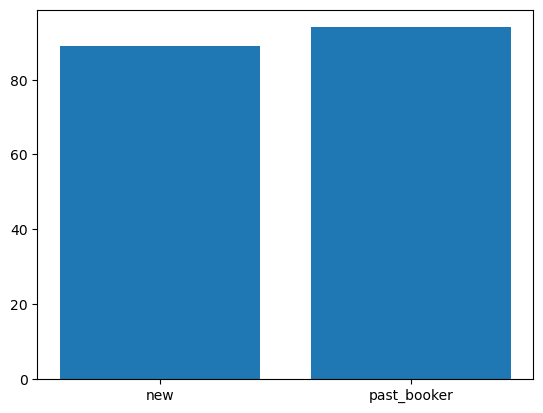

In [272]:
plt.bar(flop_10_n_t_gusf['guest_user_stage_first'],flop_10_n_t_gusf['count'])
plt.show()

In [273]:
contacts_listings_users = contacts_listings.merge(users, on = 'id_guest_anon')
contacts_listings_users = contacts_listings_users[contacts_listings_users['listing_neighborhood']!= '-unknown-']
contacts_listings_users = contacts_listings_users[contacts_listings_users['country']!= 'BR']
contacts_listings_users_top = contacts_listings_users['listing_neighborhood'].value_counts().index
contacts_listings_users_top = contacts_listings_users[contacts_listings_users['listing_neighborhood'].isin(contacts_listings_users_top)]
contacts_listings_users_top_cn = pd.crosstab(contacts_listings_users_top['listing_neighborhood'],contacts_listings_users_top['country'])
contacts_listings_users_flop = contacts_listings_users['listing_neighborhood'].value_counts().nsmallest(10).index
contacts_listings_users_flop = contacts_listings_users[contacts_listings_users['listing_neighborhood'].isin(contacts_listings_users_flop)]
contacts_listings_users_flop_cn = pd.crosstab(contacts_listings_users_flop['listing_neighborhood'],contacts_listings_users_flop['country'])
contacts_listings_users_top_cn.head()

country,AE,AO,AR,AT,AU,AW,AZ,BA,BB,BD,...,TH,TR,TT,TW,UA,US,UY,VE,VN,ZA
listing_neighborhood,,,,,,,,,,,,,,,,,,,,,
Abolição,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Andaraí,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,3,0,0,0,0
Barra da Tijuca,0,0,88,0,1,0,0,0,0,2,...,1,0,0,1,0,80,3,0,0,0
Barros Filho,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
Bonsucesso,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [274]:
#calcolare quanto i primi 5 paesi rappresentano sul totale. 
#vedere quale tipologia di stanza prevale per ogni quartiere. 

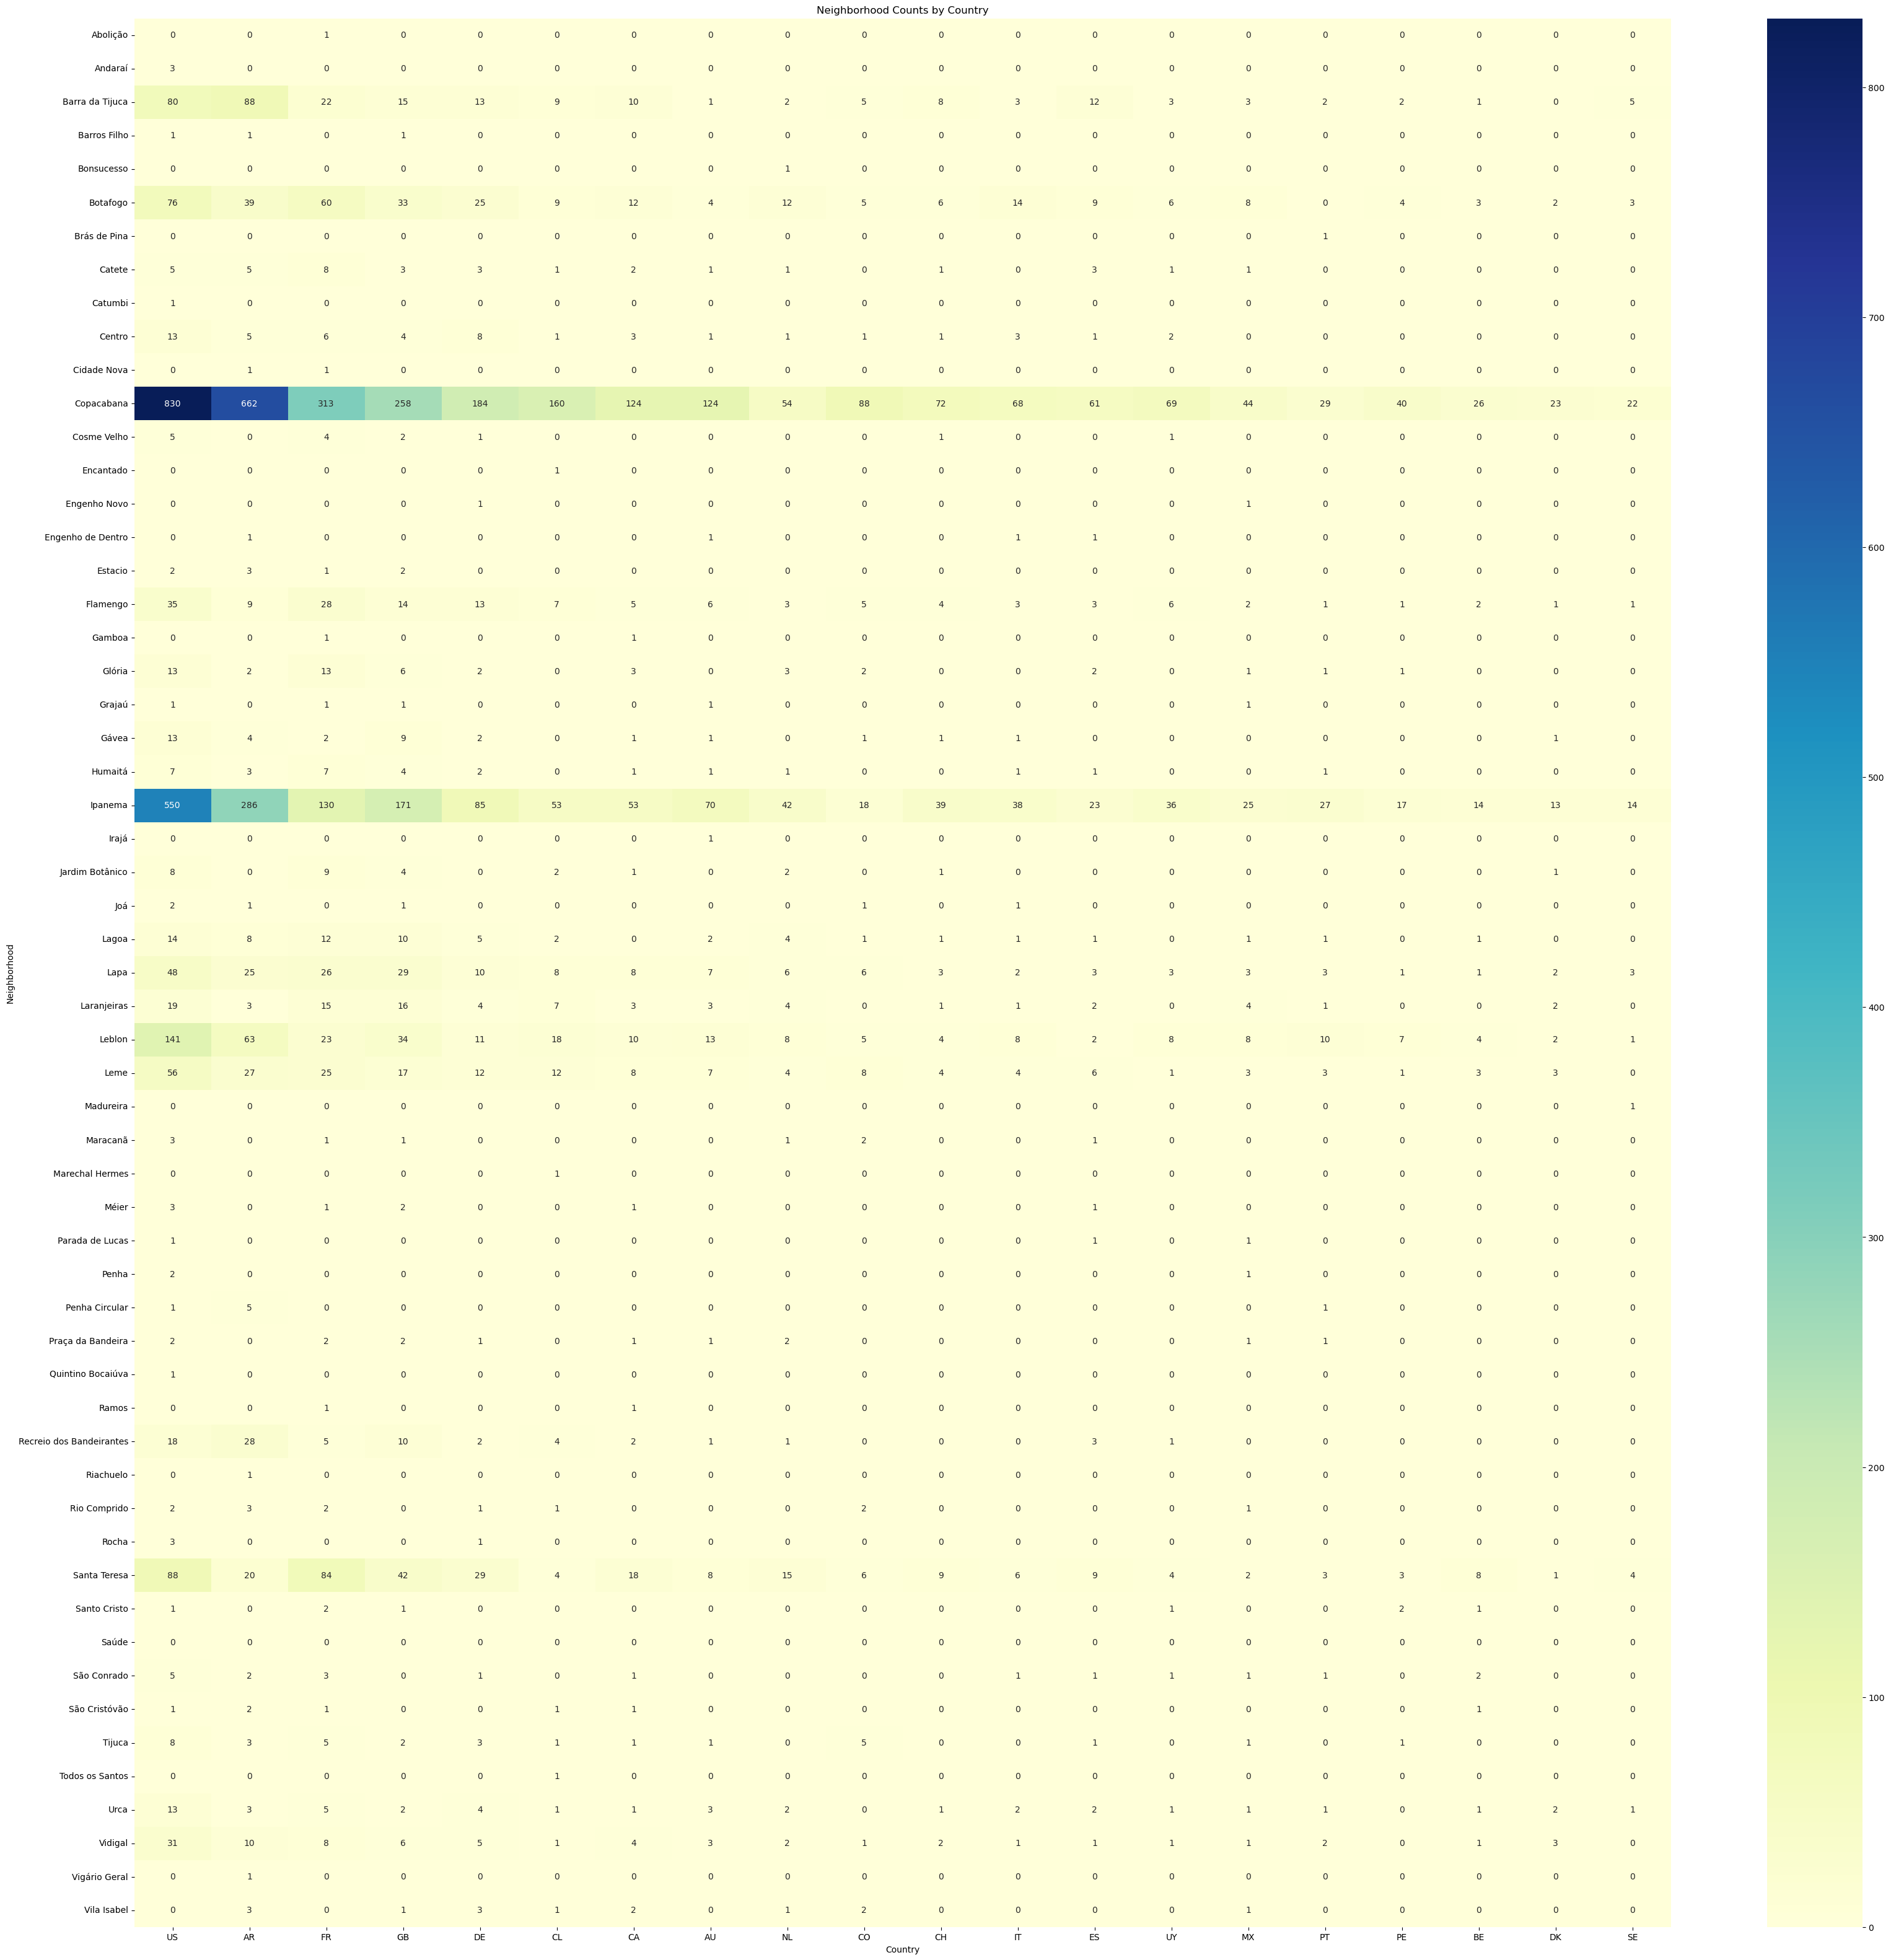

In [275]:
#contacts_listings_users_cn_top = pd.DataFrame(contacts_listings_users).set_index('country').T

# Compute the sum of each country (column)
country_sums = contacts_listings_users_top_cn.sum(axis=0).nlargest(20)

# Filter the DataFrame to keep only the top 20 columns
filtered_df = contacts_listings_users_top_cn[country_sums.index]

# Plot the filtered data
plt.figure(figsize=(40, 40))
sns.heatmap(filtered_df, annot=True, fmt="d", cmap="YlGnBu")
plt.title('Neighborhood Counts by Country')
plt.xlabel('Country')
plt.ylabel('Neighborhood')
plt.show()
#top 5 countries that have the most bookings are US,AR,FR,GB,DE. 

In [276]:
neighbourhoods_count_t = contacts_listings_t.groupby('listing_neighborhood')['total_reviews'].count().reset_index(name = 'count')
#neighbourhoods_count['count'] = neighbourhoods_count['count']/neighbourhoods_count['count'].sum()
neighbourhoods_count_t.sort_values(by = 'count', ascending = False, inplace = True)
neighbourhoods_count_t.head()

,listing_neighborhood,count
9,Copacabana,2847
21,Ipanema,1391
28,Leblon,462
2,Barra da Tijuca,361
41,Santa Teresa,358


In [277]:
neighbourhoods_count_f = contacts_listings_f.groupby('listing_neighborhood')['total_reviews'].count().reset_index(name = 'count')
#neighbourhoods_count['count'] = neighbourhoods_count['count']/neighbourhoods_count['count'].sum()
neighbourhoods_count_f.sort_values(by = 'count', ascending = False, inplace = True)
neighbourhoods_count_f.head()

,listing_neighborhood,count
12,Copacabana,3562
27,Ipanema,1519
1,Barra da Tijuca,625
34,Leblon,539
5,Botafogo,439


In [278]:
neighbourhoods_count = neighbourhoods_count_t.merge(neighbourhoods_count_f, on = 'listing_neighborhood')
neighbourhoods_count.head()

,listing_neighborhood,count_x,count_y
0,Copacabana,2847,3562
1,Ipanema,1391,1519
2,Leblon,462,539
3,Barra da Tijuca,361,625
4,Santa Teresa,358,226


In [282]:
neighbourhoods_count['ratio_x'] = neighbourhoods_count['count_x']/(neighbourhoods_count['count_x'] + neighbourhoods_count['count_y'])
neighbourhoods_count['ratio_y'] = neighbourhoods_count['count_y']/(neighbourhoods_count['count_x'] + neighbourhoods_count['count_y'])
neighbourhoods_count.head()

,listing_neighborhood,count_x,count_y,ratio_x,ratio_y
0,Copacabana,2847,3562,0.444219,0.555781
1,Ipanema,1391,1519,0.478007,0.521993
2,Leblon,462,539,0.461538,0.538462
3,Barra da Tijuca,361,625,0.366126,0.633874
4,Santa Teresa,358,226,0.613014,0.386986


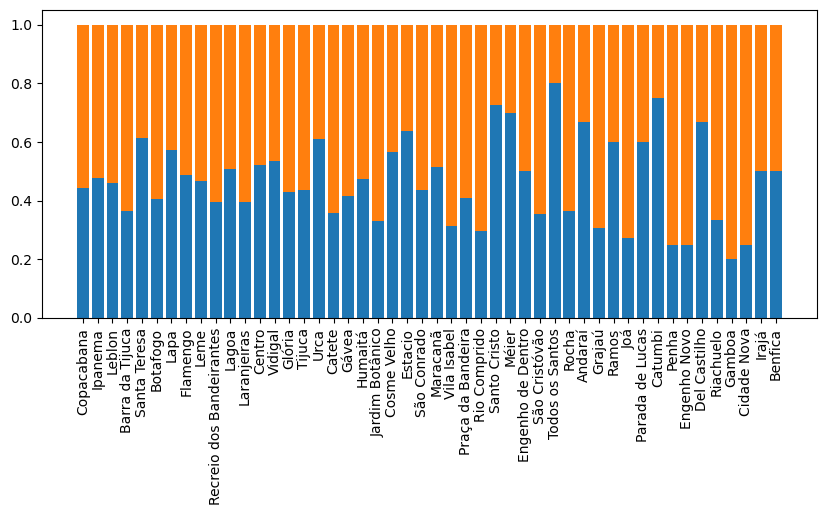

In [283]:
plt.figure(figsize = (10,4))
plt.bar(neighbourhoods_count['listing_neighborhood'],neighbourhoods_count['ratio_x'])
plt.bar(neighbourhoods_count['listing_neighborhood'],neighbourhoods_count['ratio_y'], bottom = neighbourhoods_count['ratio_x'])
plt.xticks(neighbourhoods_count['listing_neighborhood'], rotation = 'vertical')
plt.show()

In [300]:
contacts_listings_users_t = contacts_listings_users[contacts_listings_users['booked'] == True]
countries = contacts_listings_users_t.groupby('country')['booked'].count().reset_index(name = 'count')
countries.sort_values(by = 'count', ascending = False, inplace = True)
top_5_countries = countries.head(5)
ratio_5_countries = top_5_countries['count'].sum()/countries['count'].sum()
top_5_countries
ratio_5_countries

0.6339040372014373

In [310]:
rooms = contacts_listings.groupby(['listing_neighborhood','room_type']).size().reset_index(name = 'count_room_type')
room = rooms.loc[rooms.groupby('listing_neighborhood')['count_room_type'].idxmax()]
room.sort_values(by = 'count_room_type', ascending = False, inplace = True)
room.head()

,listing_neighborhood,room_type,count_room_type
29,Copacabana,Entire home/apt,5313
61,Ipanema,Entire home/apt,2511
3,Barra da Tijuca,Entire home/apt,823
79,Leblon,Entire home/apt,812
12,Botafogo,Entire home/apt,491


In [311]:
room.tail()

,listing_neighborhood,room_type,count_room_type
39,Engenho da Rainha,Entire home/apt,1
28,Coelho Neto,Private room,1
9,Bonsucesso,Entire home/apt,1
7,Benfica,Entire home/apt,1
141,Vila da Penha,Shared room,1
